Импортируем нужные библиотеки

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import Ridge, Lasso, ElasticNet
from sklearn.preprocessing import StandardScaler, LabelEncoder

Загружаем два датафрейма - 'train.csv' и 'test.csv'

In [3]:
train_df = pd.read_csv('train.csv')
test_df = pd.read_csv('test.csv')

Визуализация распределения 'RiskScore'

/tmp/ipykernel_7532/1077761136.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['RiskScore'])


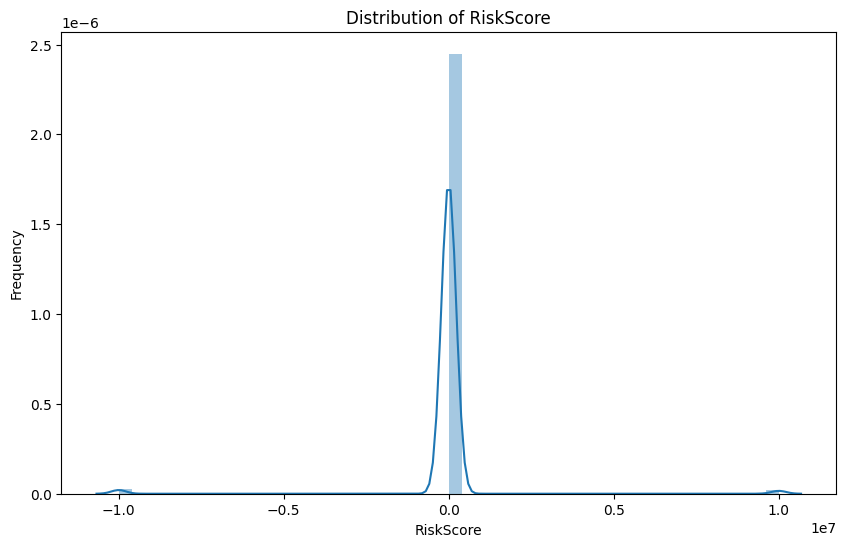

In [4]:
plt.figure(figsize=(10, 6))
sns.distplot(train_df['RiskScore'])
plt.xlabel('RiskScore')
plt.ylabel('Frequency')
plt.title('Distribution of RiskScore')
plt.show()

Обрабатываем данные train_df. Удаляем все столбцы с нечисловыми данными. Удаляем строки, которые содержат Nan.

In [9]:
train_df = train_df.drop(columns=['ApplicationDate', 'HomeOwnershipStatus', 'MaritalStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel'])
# Удаление строк с NaN
train_df = train_df.dropna()

# Удаление дубликатов в train_df
train_df.drop_duplicates(inplace=True)

Корреляционная матрица

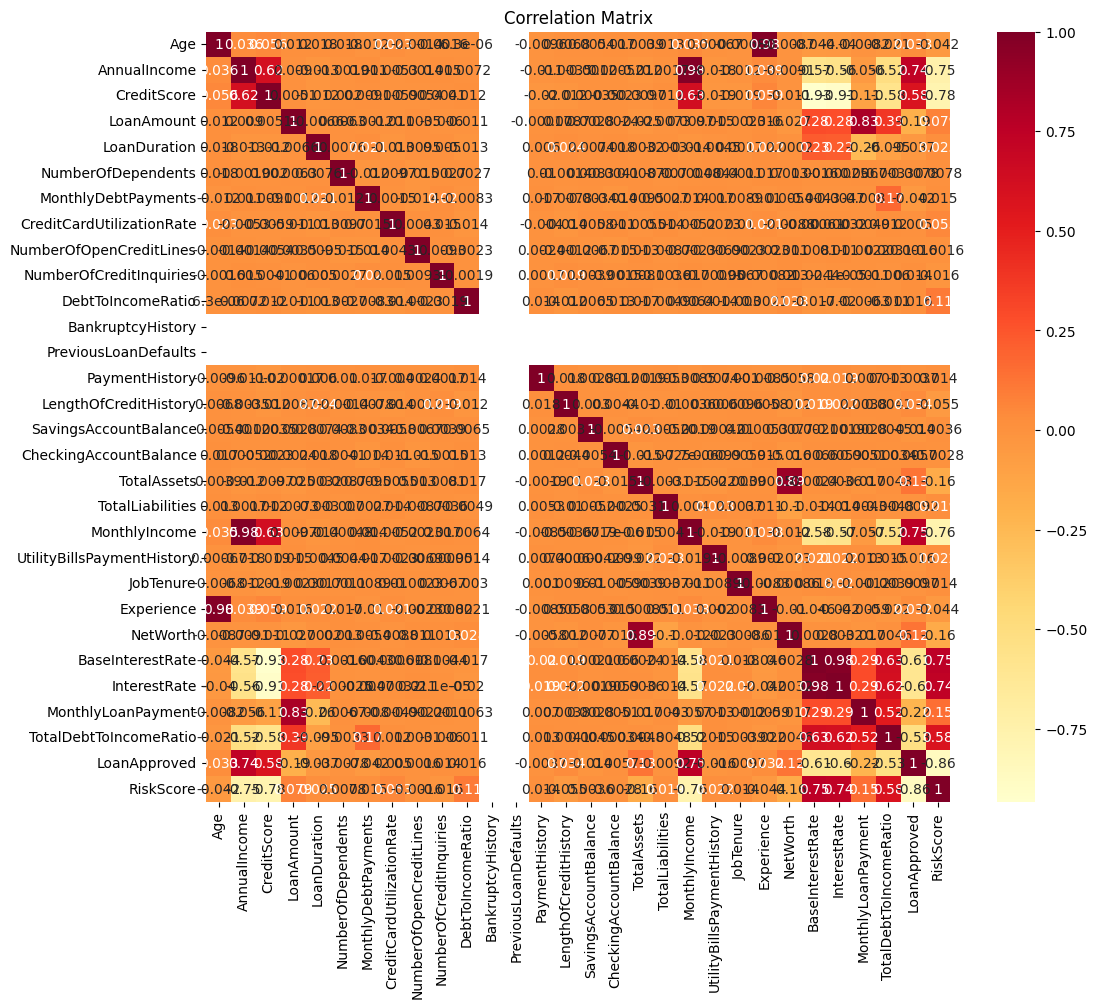

In [10]:
plt.figure(figsize=(12, 10))
corr_matrix = train_df.corr()
sns.heatmap(corr_matrix, annot=True, cmap='YlOrRd')
plt.title('Correlation Matrix')
plt.show()

Визуализация выбросов

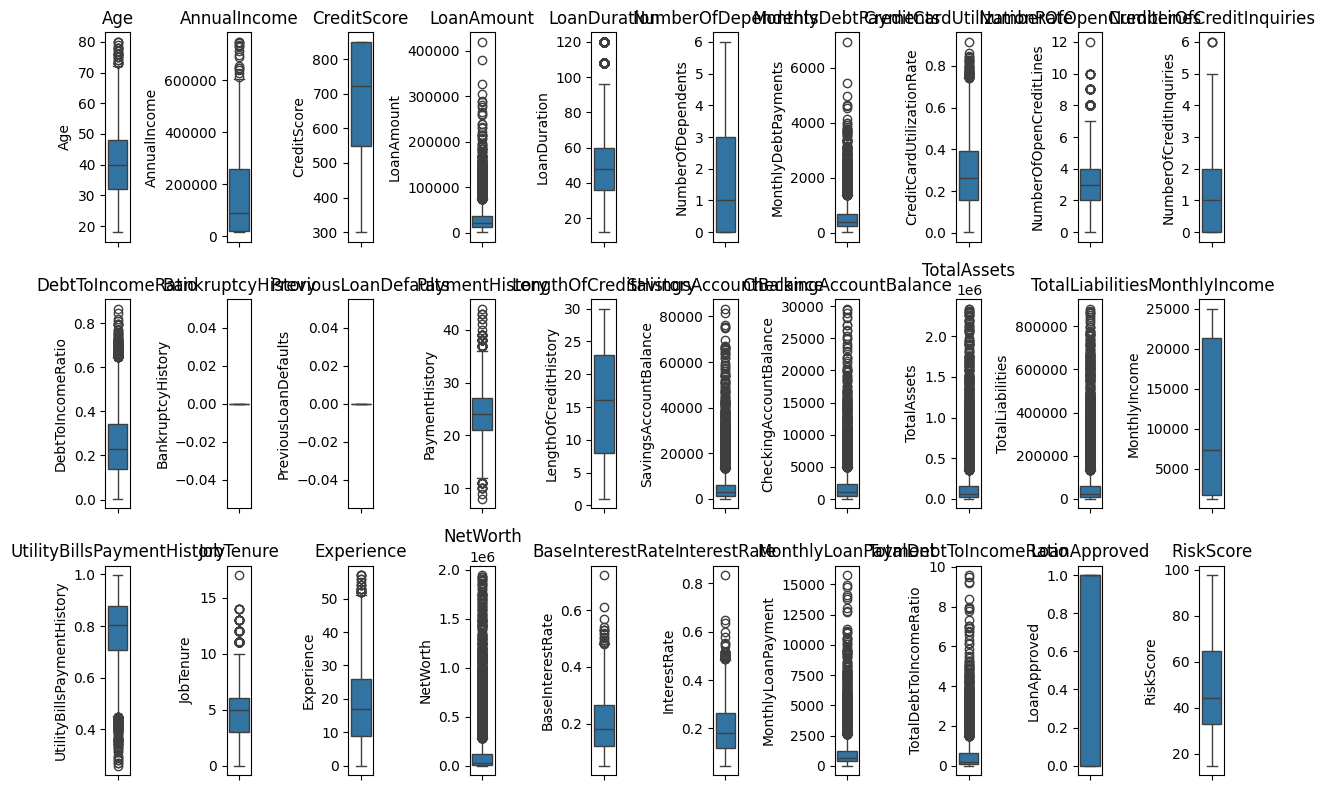

In [11]:
# Определяем количество числовых столбцов
num_numeric_cols = len(train_df.select_dtypes(include='number').columns)

# Вычисляем число строк и столбцов для сетки
num_rows = 3
num_cols = (num_numeric_cols + 2) // 3

# Создаем фигуру и сетку
plt.figure(figsize=(12, 8))
for i, col in enumerate(train_df.select_dtypes(include='number').columns):
    plt.subplot(num_rows, num_cols, i + 1)
    sns.boxplot(train_df[col])
    plt.title(col)
plt.tight_layout()
plt.show()

Визуализация распределения признаков для обработки выбросов

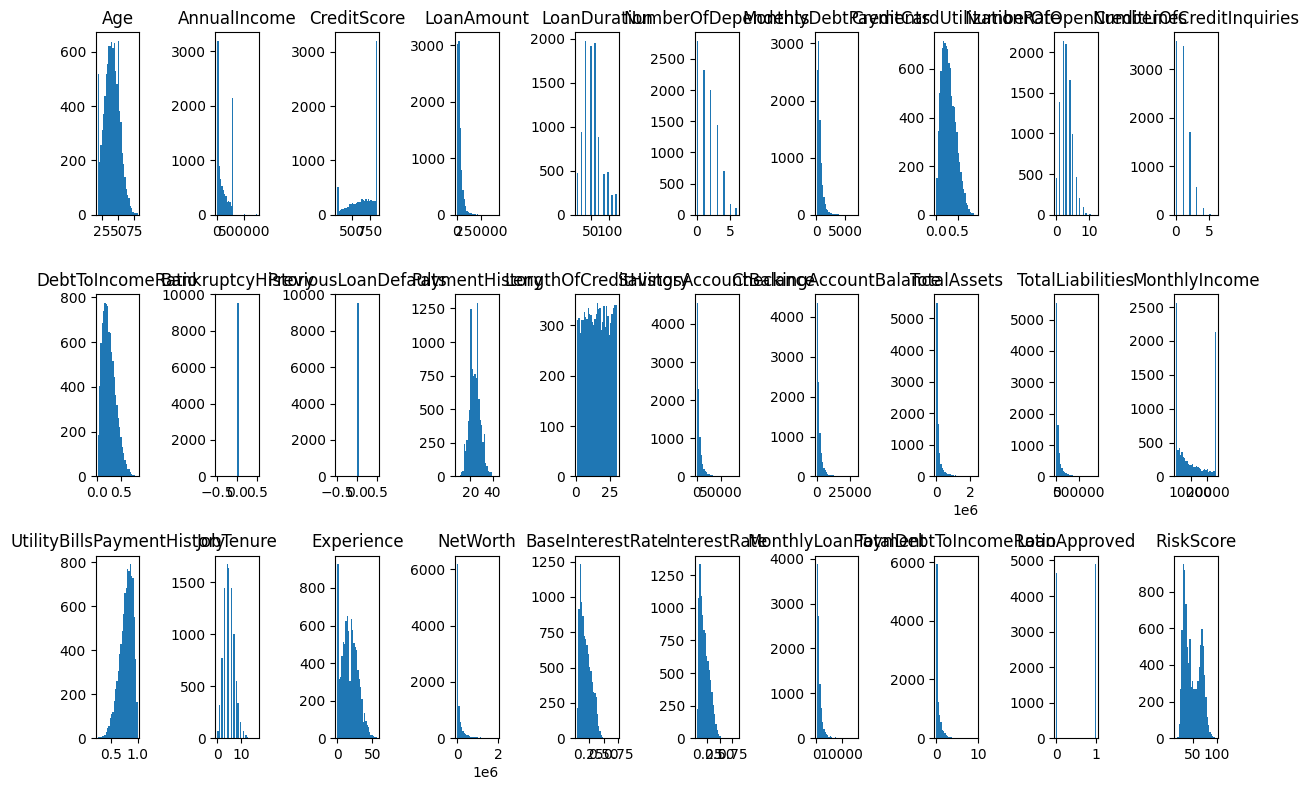

In [12]:
# Определяем количество числовых столбцов
num_numeric_cols = len(train_df.select_dtypes(include='number').columns)

# Вычисляем число строк и столбцов для сетки
num_rows = 3
num_cols = (num_numeric_cols + 2) // 3

# Создаем фигуру и сетку
plt.figure(figsize=(12, 8))
for i, col in enumerate(train_df.select_dtypes(include='number').columns):
    plt.subplot(num_rows, num_cols, i + 1)
    plt.hist(train_df[col].dropna(), bins=30)  # Используем plt.hist для упрощения
    plt.title(col)
plt.tight_layout()
plt.show()

Удаляем выбросы и меняем их на медианы

In [13]:
for col in train_df.select_dtypes(include='number').columns:
    q1 = train_df[col].quantile(0.25)
    q3 = train_df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 16.0 * iqr
    upper_bound = q3 + 16.0 * iqr
    train_df[col] = np.where(train_df[col] < lower_bound, train_df[col].median(), train_df[col])
    train_df[col] = np.where(train_df[col] > upper_bound, train_df[col].median(), train_df[col])

Тоже самое для test_df

In [15]:
#test_df = test_df.drop(columns=['ApplicationDate', 'HomeOwnershipStatus', 'MaritalStatus', 'LoanPurpose', 'EmploymentStatus', 'EducationLevel'])
# Удаление строк с NaN
test_df = test_df.dropna()

# Удаление выбросов для test_df
for col in test_df.select_dtypes(include='number').columns:
    q1 = test_df[col].quantile(0.25)
    q3 = test_df[col].quantile(0.75)
    iqr = q3 - q1
    lower_bound = q1 - 16.0 * iqr
    upper_bound = q3 + 16.0 * iqr
    test_df[col] = np.where(test_df[col] < lower_bound, test_df[col].median(), test_df[col])
    test_df[col] = np.where(test_df[col] > upper_bound, test_df[col].median(), test_df[col])

Столбец 'RiskScore' выделяется в качестве целевой переменной (y_column). Остальные столбцы используются в качестве признаков (X_columns). Данные разделяем на обучающую и валидационную выборки с использованием функции train_test_split().

In [16]:
y_column = train_df['RiskScore']
X_columns = train_df.drop(columns=['RiskScore'])
X_train, X_valid, y_train, y_valid = train_test_split(
    X_columns, y_column, test_size=0.3, random_state=0)

Масштабирование данных при помощи StandardScaler

In [17]:
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valid = scaler.transform(X_valid)
X_test = test_df.drop(columns=['ID'])
X_test = scaler.transform(X_test)

Используем модель Ridge regression. Обучаем на обучающей выборке X_train и y_train. Производится предсказание на валидационной выборке X_valid и вычисляется среднеквадратичная ошибка предсказаний

In [18]:
ridge_reg = Ridge(random_state=41, alpha=1 , max_iter=100)
ridge_reg.fit(X_train, y_train)
ridge_scaled_valid_pred = ridge_reg.predict(X_valid)
np.sqrt(mean_squared_error(ridge_scaled_valid_pred, y_valid))

5.538424844291263

Предсказание на тестовых данных

In [19]:
test_pred = ridge_reg.predict(X_test)

Создание DataFrame с предсказаниями

In [20]:
df_out = pd.DataFrame({'ID': np.arange(len(test_pred)), 'RiskScore': test_pred})

Визуализация распределения 'RiskScore' после обработки данных

/tmp/ipykernel_7890/711222560.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(train_df['RiskScore'])


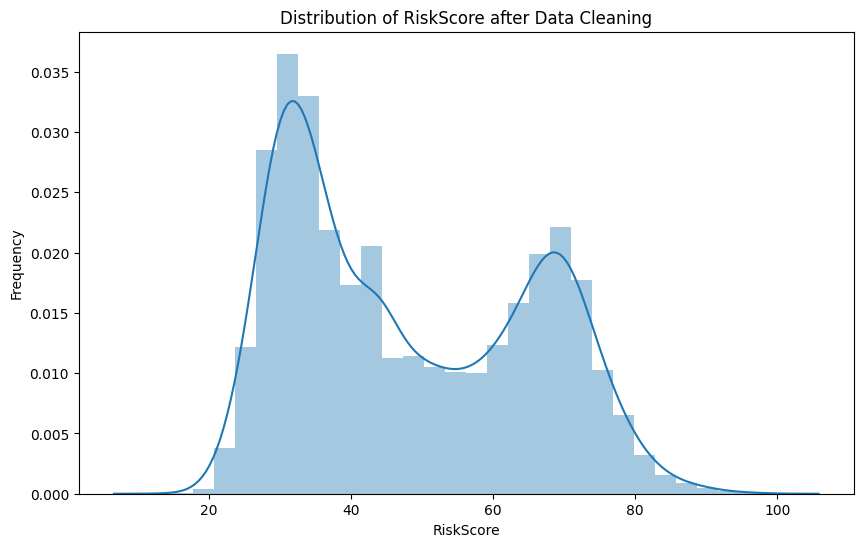

In [21]:
plt.figure(figsize=(10, 6))
sns.distplot(train_df['RiskScore'])
plt.xlabel('RiskScore')
plt.ylabel('Frequency')
plt.title('Distribution of RiskScore after Data Cleaning')
plt.show()

Сохранение DataFrame в CSV-файл

In [ ]:
df_out.to_csv('submission.csv', index=False)